<a href="https://colab.research.google.com/github/sabamadadi/10-Chemistry-Codes/blob/main/projects/neurons/load_Allen_Visual_Behavior_from_SDK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
This notebook shows how to access and interact with 2-photon calcium imaging data collected as part of the Allen Institute's Visual Behavior 2P project.

You can learn more about this dataset, behavioral task, and find other useful tools here:
[Overview page](https://allenswdb.github.io/physiology/ophys/visual-behavior/VB-Ophys.html) and [Allen Brain Atlas](allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html)

Specifically, this notebook will show how to load neural data for all imaging planes in one 2-photon imaging session into a single 'tidy' dataframe, make  simple event-triggered plots, and do some basic analysis using scikit-learn.

This is designed to demonstrate a simple method for interacting with the Visual Behavior 2P data. Many aspects of the dataset are not explored here.

# Set up environment and import packages

We have built a package called `brain_observatory_utilities` which contains some useful convenience functions. The `allenSDK` is a dependency of this package and will be automatically installed when you install `brain_observatory_utilities` per the instrutions below.

We will first install `brain_observatory_utilities` into our colab environment by running the commands below. When this cell is complete, click on the `RESTART RUNTIME` button that appears at the end of the output. Note that running this cell will produce a long list of outputs and some error messages. Clicking `RESTART RUNTIME` at the end will resolve these issues.

You can minimize the cell after you are done to hide the output.

In [1]:
# @title Install packages
!pip install pip --upgrade --quiet
!pip install brain_observatory_utilities --upgrade --quiet
!pip install pandas --quiet
!pip install seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.0/336.0 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.1/973.1 kB 42.8 MB/s eta 0:00:

#### Next we will import packages we need later in the notebook

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as ophys_formatting
import brain_observatory_utilities.utilities.general_utilities as utilities

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)
# this line may be needed if you run into Error in pandas query function
# Otherwise set the engine to python in queries made throught the book
# pd.DataFrame.query = lambda self, expr, **kwargs: self.query(expr, engine='python', **kwargs)

# Load the session and experiment summary tables

The AllenSDK provides functionality for downloading tables that describe all sessions and experiments (individual imaging planes) in the Visual Behavior 2P dataset. We first download the data cache:

In [3]:
data_storage_directory = "./temp"  # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 247k/247k [00:00<00:00, 2.39MMB/s]
behavior_session_table.csv: 100%|██████████| 1.59M/1.59M [00:00<00:00, 13.1MMB/s]
ophys_experiment_table.csv: 100%|██████████| 657k/657k [00:00<00:00, 6.72MMB/s]
ophys_cells_table.csv: 100%|██████████| 4.28M/4.28M [00:00<00:00, 19.9MMB/s]
/usr/local/lib/python3.10/dist-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_pr

- `Ophys_session_table` contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple ophys experiment ids. Each ophys session id will also have a unique behavior session id.
- `Behavior_session_table` contains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have ophys session ids were training sessions.
- `Ophys_experiment_table` contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique experiment ids. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the `ophys_container_id` column that can be found in both `ophys_session_table` and `ophys_experiment_table`.

Then we can access the session and experiment tables directly.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane.

In [4]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

We can then view the contents of the session table. Note that this contains a lot of useful metadata about each session. One of the columns, `ophys_experiment_id` provides a list of the experiments (aka imaging planes) that are associated with each session.

In [5]:
session_table.head()

,behavior_session_id,ophys_container_id,mouse_id,indicator,full_genotype,driver_line,cre_line,reporter_line,sex,age_in_days,imaging_plane_group_count,project_code,session_type,session_number,image_set,behavior_type,experience_level,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,date_of_acquisition,equipment_name,num_depths_per_area,ophys_experiment_id,num_targeted_structures
ophys_session_id,,,,,,,,,,,,,,,,,,,,,,,,,
951410079,951520319,"[1018028339, 1018028342, 1018028345, 101802835...",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,4,VisualBehaviorMultiscope,OPHYS_1_images_A,1,images_A,active_behavior,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,4,"[951980471, 951980473, 951980475, 951980479, 9...",2
952430817,952554548,"[1018028339, 1018028345, 1018028354, 1018028357]",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,209,3,VisualBehaviorMultiscope,OPHYS_2_images_A_passive,2,images_A,passive_viewing,Familiar,0,66,1,2019-09-23 08:45:38.490000+00:00,MESO.1,4,"[953659743, 953659745, 953659749, 953659752]",2
954954402,953982960,"[1018028339, 1018028342, 1018028345, 101802835...",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,210,4,VisualBehaviorMultiscope,OPHYS_3_images_A,3,images_A,active_behavior,Familiar,0,67,2,2019-09-24 09:01:31.582000+00:00,MESO.1,4,"[958527464, 958527471, 958527474, 958527479, 9...",2
955775716,956010809,"[1018028339, 1018028342, 1018028345]",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,212,2,VisualBehaviorMultiscope,OPHYS_3_images_A,3,images_A,active_behavior,Familiar,1,68,3,2019-09-26 09:22:21.772000+00:00,MESO.1,4,"[956941841, 956941844, 956941846]",2
957020350,957032492,"[1018028339, 1018028342, 1018028345, 101802835...",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,213,4,VisualBehaviorMultiscope,OPHYS_4_images_B,4,images_B,active_behavior,Novel 1,0,0,4,2019-09-27 08:58:37.005000+00:00,MESO.1,4,"[957759562, 957759564, 957759566, 957759570, 9...",2


The experiment table has one row per experiment. Note that the `ophys_session_id` column links each experiment to its associated session in the session_table.

In [6]:
experiment_table.head()

,behavior_session_id,ophys_session_id,ophys_container_id,mouse_id,indicator,full_genotype,driver_line,cre_line,reporter_line,sex,age_in_days,imaging_depth,targeted_structure,targeted_imaging_depth,imaging_plane_group,project_code,session_type,session_number,image_set,behavior_type,passive,experience_level,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,date_of_acquisition,equipment_name,published_at,isi_experiment_id,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951980471,951520319,951410079,1018028342,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,150,VISp,150,0,VisualBehaviorMultiscope,OPHYS_1_images_A,1,A,active_behavior,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,0
951980473,951520319,951410079,1018028345,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,225,VISp,225,0,VisualBehaviorMultiscope,OPHYS_1_images_A,1,A,active_behavior,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,1
951980475,951520319,951410079,1018028339,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,75,VISp,75,1,VisualBehaviorMultiscope,OPHYS_1_images_A,1,A,active_behavior,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,2
951980479,951520319,951410079,1018028354,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,150,VISl,150,2,VisualBehaviorMultiscope,OPHYS_1_images_A,1,A,active_behavior,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,3
951980481,951520319,951410079,1018028357,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,225,VISl,225,2,VisualBehaviorMultiscope,OPHYS_1_images_A,1,A,active_behavior,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,4


# Load one example session
We are going to select one session from this table, session 854060305. This is a session with Sst-IRES-Cre mouse, which expressed GCaMP6f in Sst+ inhibitory interneurons. There were 6 simultaneously acquired imaging planes for this session.
We can view metadata for this session as follows:

In [7]:
ophys_session_id = 854060305
session_table.loc[ophys_session_id]

behavior_session_id                                                        854283407
ophys_container_id                 [1018028135, 1018028138, 1018028141, 101802814...
mouse_id                                                                      440631
indicator                                                                    GCaMP6f
full_genotype                          Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
driver_line                                                           [Sst-IRES-Cre]
cre_line                                                                Sst-IRES-Cre
reporter_line                                             Ai148(TIT2L-GC6f-ICL-tTA2)
sex                                                                                M
age_in_days                                                                      129
imaging_plane_group_count                                                          3
project_code                                                Visua

# Download all associated experiments

Each session consists of one or more 'experiments', in which each experiment is a single imaging plane

Each mesoscope session has up to 8 experiments associated with the session. We will load all sessions into a dictionary with the experiment IDs as the keys

The first time that this cell is run, the associated NWB files will be downloaded to your local `data_storage_directory`. Subsequent runs of this cell will be faster since the data will already be cached locally.

In [8]:
experiments = {}
ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

behavior_ophys_experiment_854759890.nwb: 100%|██████████| 232M/232M [00:09<00:00, 23.3MMB/s]
/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_854759894.nwb: 100%|██████████| 252M/252M [00:06<00:00, 40.0MMB/s]
/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_854759896.nwb: 100%|██████████| 232M/232M [00:06<00:00, 35.6MMB/s]
/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_854759898.nwb: 100%|██████████| 246M/246M [00:06<00:00, 39.6MMB/s]
/usr/local/lib/python3.10/dist-pac

## View the max projection and one cell ROI for one of the experiments
We can view the `cell_specimen_table` for one experiment, which contains information about each identified cell in that experiment

In [9]:
experiment = experiments[ophys_experiment_ids[1]]
experiment.cell_specimen_table.head()

,cell_roi_id,height,mask_image_plane,max_correction_down,max_correction_left,max_correction_right,max_correction_up,valid_roi,width,x,y,roi_mask
cell_specimen_id,,,,,,,,,,,,
1086557083,1080855636,17,0,5.0,7.0,4.0,7.0,True,19,173,384,"[[False, False, False, False, False, False, Fa..."
1086557639,1080855643,16,0,5.0,7.0,4.0,7.0,True,14,363,447,"[[False, False, False, False, False, False, Fa..."
1086559064,1080855660,19,1,5.0,7.0,4.0,7.0,True,17,24,221,"[[False, False, False, False, False, False, Fa..."
1086558114,1080855673,18,0,5.0,7.0,4.0,7.0,True,13,74,305,"[[False, False, False, False, False, False, Fa..."
1086558224,1080855678,19,0,5.0,7.0,4.0,7.0,True,18,478,284,"[[False, False, False, False, False, False, Fa..."


We can then visualize the max projection and one of the identified ROIs

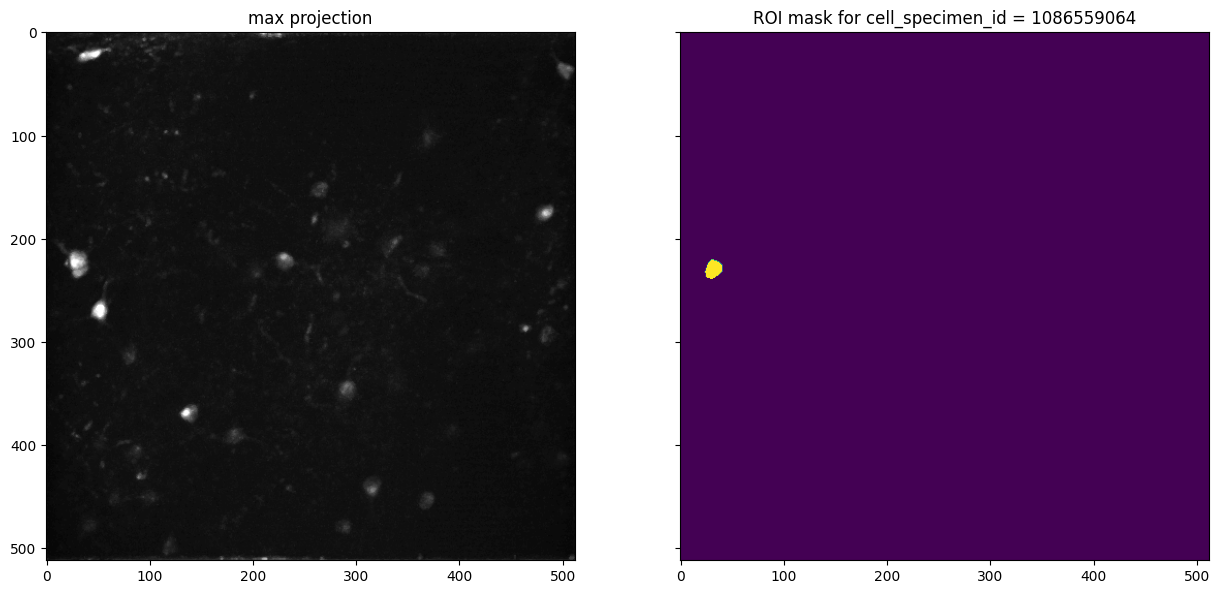

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)
ax[0].imshow(experiment.max_projection, cmap='gray')
ax[0].set_title('max projection')

cell_specimen_id = experiment.cell_specimen_table.index[2]
ax[1].imshow(experiment.cell_specimen_table.loc[cell_specimen_id]['roi_mask'])
ax[1].set_title('ROI mask for cell_specimen_id = {}'.format(cell_specimen_id))
fig.show()

## Load neural data into memory


The cell below will load the neural data into memory in the pandas 'tidy' format by iterating over each of the 6 experiments and using some helpful tools from the `brain_observatory_utilities` package that was imported above as `ophys`.

It will also include a subset of metadata from `ophys_experiment_table` to facilitate splitting by depth, structure (aka cortical area), cre line (aka cell class), etc.

Note that 'tidy' data means that each row represents only one observation. Observations are stacked vertically. Thus, the `timestamps` colums will repeat for every cell in the dataset.

In [11]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys_formatting.build_tidy_cell_df(this_experiment)

    # add some columns with metadata for the experiment
    metadata_keys = [
      'ophys_experiment_id',
      'ophys_session_id',
      'targeted_structure',
      'imaging_depth',
      'equipment_name',
      'cre_line',
      'mouse_id',
      'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]

    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)

# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


We can then look at some attributes of the `neural_data` dataframe we have created.

It is ~2.5 million rows long:

In [12]:
len(neural_data)

2561543

It is so long because has one row for each timestamp for each cell.

Below are the first 5 entries. Again, note that the `tidy` format means that each row has only one observation, which represents a single GCaMP6 fluorescnce value for a single neuron.

In [13]:
neural_data.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,10.52216,0.400583,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
1,10.61538,0.126125,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
2,10.70860,-0.083087,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
3,10.80182,0.158960,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
4,10.89504,0.301507,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M


- The `cell_roi_id` column contains unique roi ids for all cells in a given experiment, which do not repeat across ophys sessions.
- The `cell_specimen_id` column contains unique ids for cells that were matched across ophys sessions. Thus, a cell that was imaged in more than one session has multiple roi ids but one cell specimen id.

# Examine Cell IDs
We can get the unique Cell IDs in our dataset as follows:

In [14]:
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

there are 53 unique cells
cell ids are: [1086550481 1086551114 1086551301 1086557083 1086557639 1086559064
 1086558114 1086558224 1086558510 1086559206 1086557304 1086557208
 1086560061 1086559681 1086559885 1086559968 1086557470 1086547796
 1086547993 1086548118 1086554566 1086556653 1086558574 1086552296
 1086558071 1086556532 1086555222 1086558701 1086557434 1086556317
 1086555835 1086549726 1086553836 1086551540 1086551151 1086550544
 1086552709 1086553271 1086553602 1086555553 1086548072 1086553899
 1086547630 1086549303 1086549491 1086549813 1086549949 1086548658
 1086548969 1086551457 1086551645 1086550990 1086551209]


If we wanted to get the timeseries for one cell, we could query the `neural_data` dataframe. For example, to get the full timeseries for the cell with `cell_specimen_id = 1086557208`:

In [15]:
single_cell_timeseries = neural_data.query('cell_specimen_id == 1086557208')
single_cell_timeseries.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,10.52216,0.218961,0.0,0.0,1080855724,1086557208,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
1,10.61538,0.232865,0.0,0.0,1080855724,1086557208,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
2,10.70860,-0.050186,0.0,0.0,1080855724,1086557208,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
3,10.80182,0.239468,0.0,0.0,1080855724,1086557208,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
4,10.89504,0.226356,0.0,0.0,1080855724,1086557208,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M


Each cell has three types of traces:
- `dff` column is the Calcium fluorescence signal, normalized to background fluorescence.
- `events` column is deconvolved events from dff trace, which approximates neural firing rate and removes the slow decay of the Calcium signal (for more details, you can read EVENT DETECTION section in [Visual Behavior whitepaper](https://portal.brain-map.org/explore/circuits/visual-behavior-2p)).
- `filtered_events` column is events smoothed with a half-gaussian kernel.

We can then plot DeltaF/F for this cell for the full experiment as follows:

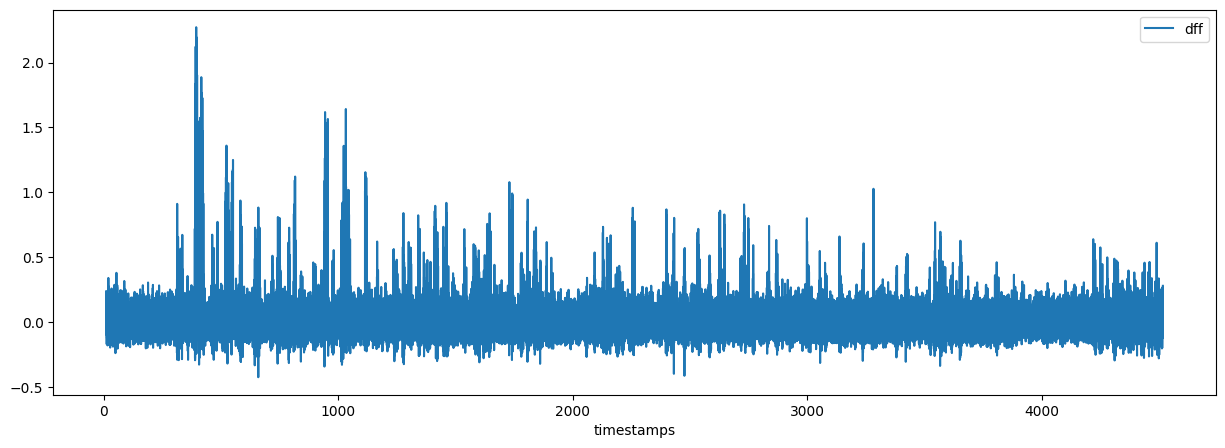

In [16]:
fig, ax = plt.subplots(figsize=(15,5))
single_cell_timeseries.plot(
    x = 'timestamps',
    y = 'dff',
    ax = ax
)
fig.show()

# Load stimulus data into memory
The stimulus table is shared across all experiments (imaging planes) in a session. We can therefore use the stimulus table for just one experiment.

We are going to drop the `image_set` column because it is not informative for our purposes. We can then view the first 10 rows of the stimulus table.

In [17]:
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations
stimulus_table.head(10)

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,is_sham_change,active,stimulus_name
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
0,0,initial_gray_screen_5min,-99,NaN,-99,310.569786,0.000000,310.569786,0,17985,False,<NA>,<NA>,-99,0,-99,False,False,spontaneous
1,1,change_detection_behavior,0,im000,-99,0.250210,310.569786,310.819996,17985,18000,False,False,False,-99,1,0,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
2,1,change_detection_behavior,0,im000,-99,0.250200,311.320396,311.570596,18030,18045,False,False,False,-99,2,0,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
3,1,change_detection_behavior,0,im000,-99,0.250170,312.071016,312.321186,18075,18090,False,False,False,-99,3,1,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
4,1,change_detection_behavior,0,im000,-99,0.250190,312.821616,313.071806,18120,18135,False,False,False,-99,4,1,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
5,1,change_detection_behavior,0,im000,-99,0.250210,313.572196,313.822406,18165,18180,False,False,False,-99,5,1,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
6,1,change_detection_behavior,0,im000,-99,0.250230,314.322816,314.573046,18210,18225,False,False,False,-99,6,1,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
7,1,change_detection_behavior,0,im000,-99,0.250210,315.073456,315.323666,18255,18270,False,False,False,-99,7,2,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
8,1,change_detection_behavior,0,im000,-99,0.250150,315.824126,316.074276,18300,18315,False,False,False,-99,8,2,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017


This table provides helpful information like image name, start, duration and stop of image presentation, and whether the image was omitted. `stimulus_block` and `stimulus_block_name` indicate the type of stimulus mice were presented at a given point in a session. To select active change detection behavior, first we need to filter the table for `change_detection_behavior` or `1` block. Note that sessions may have different number of stimulus blocks, thus `change_detection_behavior` may be assosiated with either 0 or 1 in `stimulus_block` column.

In [18]:
stimulus_table.stimulus_block_name.unique()

array(['initial_gray_screen_5min', 'change_detection_behavior',
       'post_behavior_gray_screen_5min', 'natural_movie_one'],
      dtype=object)

In [19]:
stimulus_table = stimulus_table[stimulus_table.stimulus_block_name=='change_detection_behavior']
stimulus_table.reset_index(drop=True, inplace=True) # resetting index starts df at stimulus 0
# give index a name
stimulus_table.index.name = 'stimulus_presentations_id'
stimulus_table.head(5)

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,is_sham_change,active,stimulus_name
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
0,1,change_detection_behavior,0,im000,-99,0.25021,310.569786,310.819996,17985,18000,False,False,False,-99,1,0,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
1,1,change_detection_behavior,0,im000,-99,0.25020,311.320396,311.570596,18030,18045,False,False,False,-99,2,0,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
2,1,change_detection_behavior,0,im000,-99,0.25017,312.071016,312.321186,18075,18090,False,False,False,-99,3,1,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
3,1,change_detection_behavior,0,im000,-99,0.25019,312.821616,313.071806,18120,18135,False,False,False,-99,4,1,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
4,1,change_detection_behavior,0,im000,-99,0.25021,313.572196,313.822406,18165,18180,False,False,False,-99,5,1,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017


## View the `stimulus_templates` attribute
Note that the `unwarped` column contains the image before the application of a spherical warp. All of the pixels labeled 'NaN' will be off-screen (not visible to the mouse) after the warp is applied.

All experiments in a given session will share the same `stimulus_templates`

In [20]:
experiment = experiments[ophys_experiment_ids[0]]
experiment.stimulus_templates

,unwarped,warped
image_name,,
im000,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[122, 122, 123, 125, 126, 127, 128, 129, 130,..."
im106,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[108, 109, 106, 103, 102, 104, 107, 112, 117,..."
im075,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[120, 121, 121, 121, 122, 123, 123, 122, 121,..."
im073,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[120, 120, 118, 116, 116, 119, 121, 120, 117,..."
im045,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[10, 13, 6, 0, 0, 8, 15, 13, 6, 2, 4, 9, 12, ..."
im054,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[124, 125, 127, 130, 133, 134, 136, 138, 140,..."
im031,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[233, 234, 244, 253, 253, 244, 237, 239, 246,..."
im035,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[178, 181, 189, 198, 200, 198, 196, 199, 205,..."


## View the unwarped images

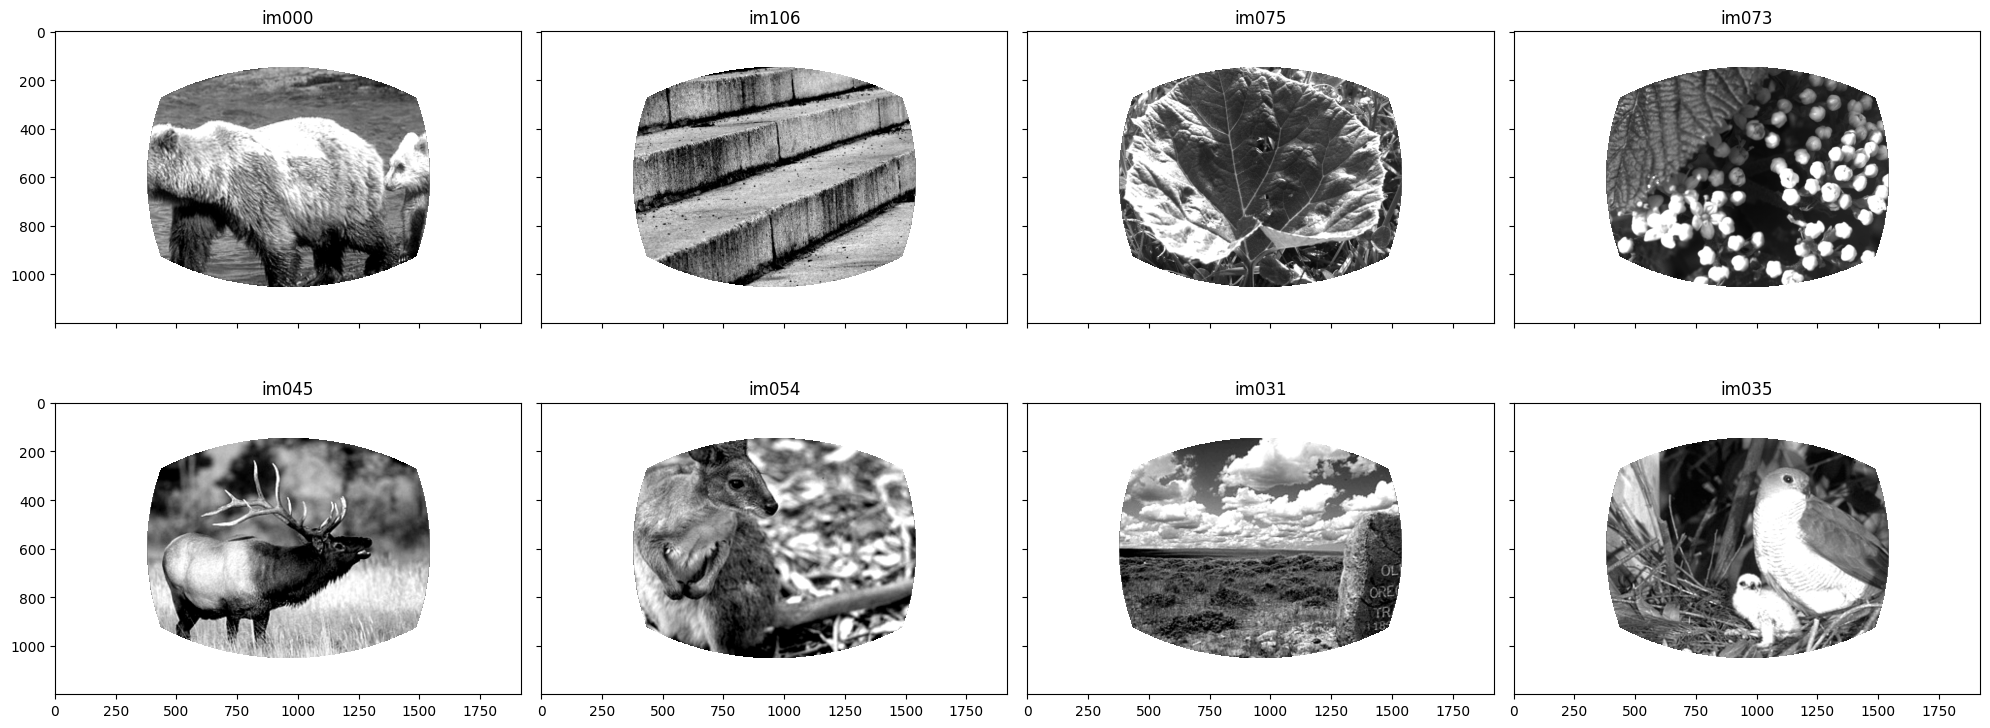

In [21]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
for ii, image_name in enumerate(experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(experiment.stimulus_templates.loc[image_name]['unwarped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()
fig.show()

## View the warped images
This represents what was actually on the screen during the session

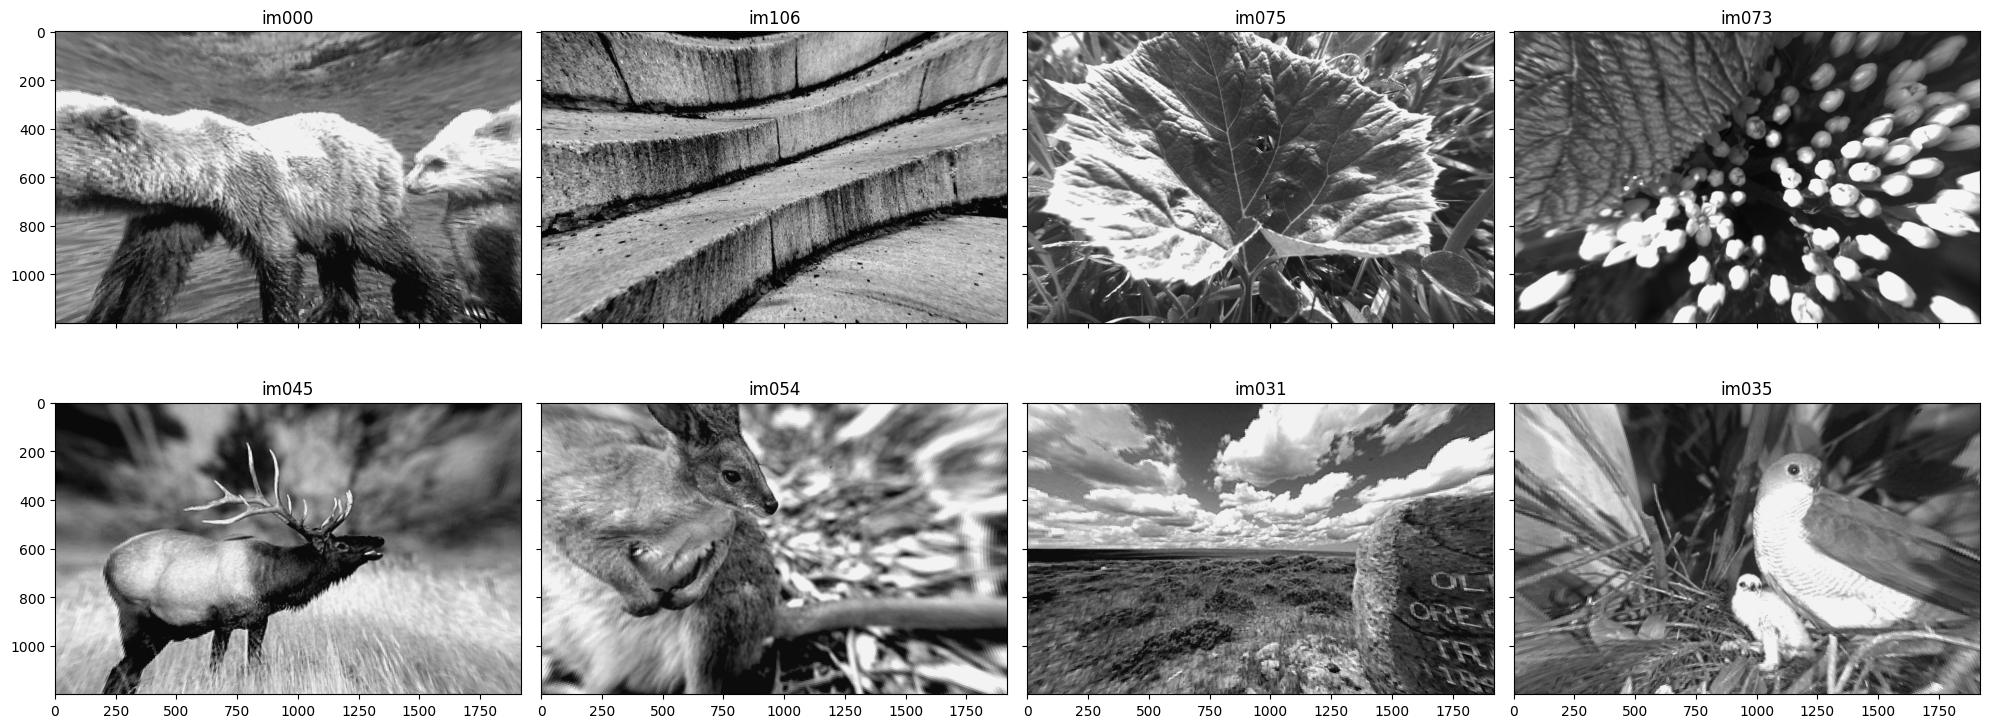

In [22]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
for ii, image_name in enumerate(experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(experiment.stimulus_templates.loc[image_name]['warped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()
fig.show()

## Describe stimulus omissions
An important feature of the task is that stimuli are shown at a very regular cadence (250 ms on, 500 ms off), but stimuli are randomly omitted with a probability of ~5%. These unexpected and random stimulus omissions could be perceived as an expectation violation by the mouse.

Omitted stimuli are denoted in the `stimulus_table` by the `omitted` column. `True` means that the stimulus that would have been shown at that time was actually omitted (and was replaced by an extended gray screen between stimuli).

We can look at the first 10 examples of omitted stimuli as follows. Note that each 'omitted' stimulus still has a 'start_time' and a 'stop_time' associated with it. This actually represents the time that a stimulus would have been shown, had it not been omitted.

Stimulus omissions are also indicated in the `image_name` column by the string `omitted`

In [23]:
stimulus_table.query('omitted', engine='python').head(10)

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,is_sham_change,active,stimulus_name
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
61,1,change_detection_behavior,8,omitted,-99,0.25,356.373816,356.623816,20731,20746,False,<NA>,True,-99,2,7,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
105,1,change_detection_behavior,8,omitted,-99,0.25,389.400806,389.650806,22711,22726,False,<NA>,True,-99,0,12,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
113,1,change_detection_behavior,8,omitted,-99,0.25,395.405686,395.655686,23071,23086,False,<NA>,True,-99,7,13,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
128,1,change_detection_behavior,8,omitted,-99,0.25,406.664926,406.914926,23746,23761,False,<NA>,True,-99,21,15,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
143,1,change_detection_behavior,8,omitted,-99,0.25,417.940786,418.190786,24422,24437,False,<NA>,True,-99,35,18,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
172,1,change_detection_behavior,8,omitted,-99,0.25,439.708536,439.958536,25727,25742,False,<NA>,True,-99,8,21,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
174,1,change_detection_behavior,8,omitted,-99,0.25,441.209796,441.459796,25817,25832,False,<NA>,True,-99,9,21,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
243,1,change_detection_behavior,8,omitted,-99,0.25,493.018766,493.268766,28923,28938,False,<NA>,True,-99,0,28,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017
254,1,change_detection_behavior,8,omitted,-99,0.25,501.275466,501.525466,29418,29433,False,<NA>,True,-99,0,29,False,True,Natural_Images_Lum_Matched_set_ophys_6_2017


# Create an event triggered response dataframe relative to omissions
If we want to see how a given cell responds when regularly flashed stimuli are omitted, we can calculate the response around each of the stimulus omissions. The `brain_observatory_utilities` package has a convenience function to do this, in the module we imported as `utilities`. We give the function:
* a dataframe of interest (containing activity from one cell)
* the t and y values of interest
* the event times
* how much time before and after each event we are interested in
* the desired sampling rate of the output - this is the rate onto which the response will be interpolated

The function will return a new dataframe with the response for the given cell, aligned to each of the events.

In [24]:
cell_id = cell_ids[11]
etr = utilities.event_triggered_response(
    data=neural_data.query('cell_specimen_id == @cell_id'),
    t='timestamps',
    y='dff',
    event_times=stimulus_table.query('omitted', engine='python')['start_time'],
    t_before=3,
    t_after=3,
    output_sampling_rate=50,
)
etr

,time,dff,event_number,stimulus_presentations_id,event_time
0,-3.00,0.043293,0,61,356.373816
1,-2.98,0.036577,0,61,356.373816
2,-2.96,0.021164,0,61,356.373816
3,-2.94,0.005752,0,61,356.373816
4,-2.92,-0.009661,0,61,356.373816
...,...,...,...,...,...
55680,2.92,0.001923,184,4796,3911.326506
55681,2.94,0.001321,184,4796,3911.326506
55682,2.96,0.001321,184,4796,3911.326506
55683,2.98,0.001321,184,4796,3911.326506


We can see that the output has colums for
* `time` - this is our new timebase relative to the events. In this case, it ranges from -3 to 3
* `dff` - this is the deltaF/F value surrounding each event, interpolated onto the new timebase. If, when calling the `event_triggered_response` function we had passed `y = 'events'`, this column would be events instead of dff.
* `event_number` - this is an integer representing the count of each event. In this example, there were 185 omissions, so they are numbered from 0 to 184
* `event_time` - this is the time of each event



The docstring for the `event_triggered_response` function can be viewed as follows:

In [25]:
help(utilities.event_triggered_response)

Help on function event_triggered_response in module brain_observatory_utilities.utilities.general_utilities:

event_triggered_response(data, t, y, event_times, t_start=None, t_end=None, t_before=None, t_after=None, output_sampling_rate=None, include_endpoint=True, output_format='tidy', interpolate=True)
    Slices a timeseries relative to a given set of event times
    to build an event-triggered response.
    
    For example, If we have data such as a measurement of neural activity
    over time and specific events in time that we want to align
    the neural activity to, this function will extract segments of the neural
    timeseries in a specified time window around each event.
    
    The times of the events need not align with the measured
    times of the neural data.
    Relative times will be calculated by linear interpolation.
    
    Parameters:
    -----------
    data: Pandas.DataFrame
        Input dataframe in tidy format
        Each row should be one observation
   

## Plot an event triggered response

The output format of the `event_triggered_response` function is designed to plug directly into Seaborn's `lineplot` plotting function. We can then view the mean response to omitted stimuli with 95% confidence intervals very easily:

<Axes: xlabel='time', ylabel='dff'>

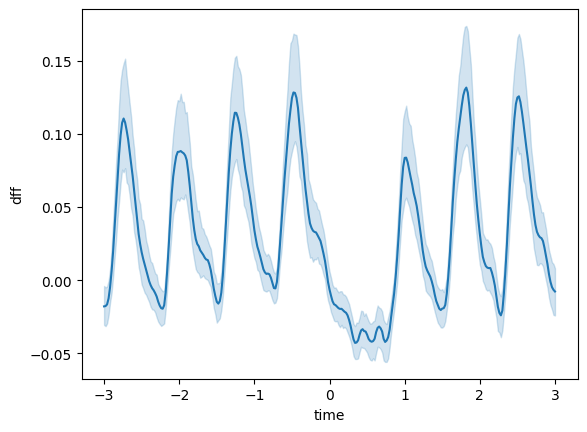

In [26]:
sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
)

Note that the regular, image-driven responses with a 750 ms inter-stimulus interval are visible everywhere except at t=0, which is when the unexpectedly omitted stimulus occured.

### Make a function to plot an event triggered average in one line

If we make a wrapper function that combines the process of calculating and plotting the event triggered response, it can be called in a single line below. By having `event_query` input variable, we can use this function to plot responses to any event of interest (omisisons, changes, hits/misses, specific images, etc)

In [27]:
def make_event_triggered_plot(df, x, y, event_query, ax, t_before=3, t_after=3):
    etr = utilities.event_triggered_response(
      data=df,
      t='timestamps',
      y=y,
      event_times=stimulus_table.query(event_query, engine='python')['start_time'],
      t_before=t_before,
      t_after=t_before,
      output_sampling_rate=50,
      )
    sns.lineplot(
      data=etr,
      x=x,
      y=y,
      n_boot=500,
      ax=ax
      )

Now plot the omission triggered response for the same cell using filtered events (these events extracted from the deltaF/F timeseries using an event extraction algorithm, then smoothed with a half-gaussian kernel) instead of dff.

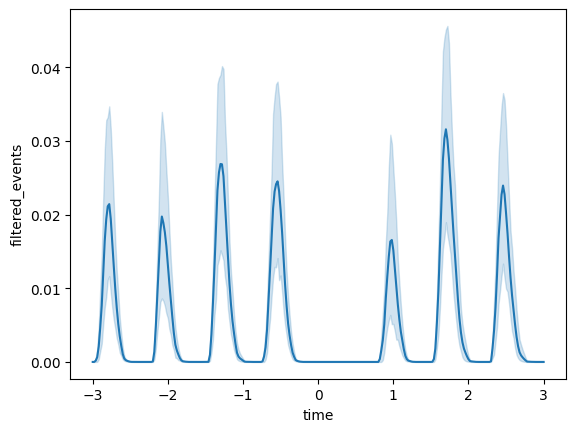

In [28]:
cell_id = cell_ids[11]
fig, ax = plt.subplots()
make_event_triggered_plot(
    df=neural_data.query('cell_specimen_id == @cell_id'),
    x='time',
    y='filtered_events',
    event_query='omitted',
    ax=ax
)
fig.show()

## Plot the responses for 10 sample cells
We can then iterate over 10 randomly chosen cells and plot their activity during omissions.

100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


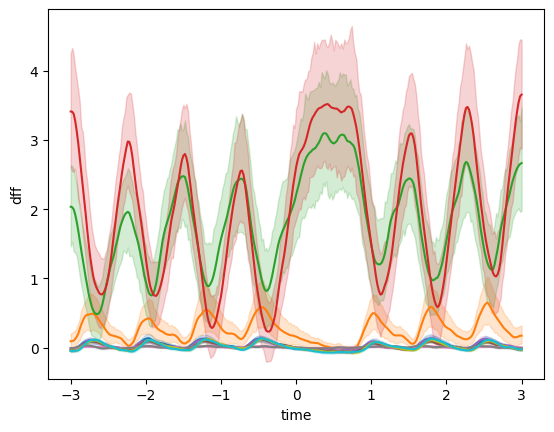

In [29]:
np.random.seed(0)
fig, ax = plt.subplots()
for cell_id in tqdm(np.random.choice(cell_ids, size=10, replace=False)):
    make_event_triggered_plot(
      df=neural_data.query('cell_specimen_id == @cell_id'),
      x='time',
      y='dff',
      event_query='omitted',
      ax=ax
      )
fig.show()

Interestingly, not all SST cells in this session do the same thing!

## Calculate the mean response for each of the individual imaging planes in this experiment
By iterating over experiment IDs, we can also calculate the mean response for each of the 6 imaging planes. Do Sst cells in different visual areas respond to omissions in a distinct way?

We will first use a Pandas `groupby` and `mean` operations to get the mean timeseries for each cell in that imaging plane:

In [30]:
mean_dff_by_experiment = (
    neural_data
    .groupby(['ophys_experiment_id','timestamps'])['dff']
    .mean()
    .reset_index()
    )

In [31]:
mean_dff_by_experiment.head()

,ophys_experiment_id,timestamps,dff
0,854759890,10.52216,0.387612
1,854759890,10.61538,0.203569
2,854759890,10.70860,0.035257
3,854759890,10.80182,0.357586
4,854759890,10.89504,0.146397


We can then iterate over our 6 experiment IDs and use our `make_event_triggered_plot` wrapper function to calculate and plot the omission triggered response for that imaging plane:

In [ ]:
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for ophys_experiment_id in tqdm(ophys_experiment_ids):
    make_event_triggered_plot(
      df=mean_dff_by_experiment.query('ophys_experiment_id == @ophys_experiment_id'),
      x='time',
      y='dff',
      event_query='omitted',
      ax=ax
      )

    # get some metadata to add to the legend
    this_exp = neural_data.query('ophys_experiment_id == @ophys_experiment_id')
    structure = this_exp['targeted_structure'].iloc[0]
    depth = this_exp['imaging_depth'].iloc[0]
    # append a string to our list of legend text
    legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))

# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1))
fig.show()

  0%|          | 0/6 [00:00<?, ?it/s]

There are clearly some large differences in the way that Sst cells respond to these unexpected stimulus omissions by area.

This example could be extended to include cells from the other two cre-lines in the dataset: The VIP-Cre line which labels VIP+ inhibitory interneurons and the Slc17a7 line, which is a pan-excitatory line.

In [ ]:
session_table['cre_line'].unique()

In addition, responses to different stimuli could be explored, along with responses relative to other behavioral measures, such as licking.

For a full description of the dataset and all available data streams, see the Visual Behavior Project Description at:
https://portal.brain-map.org/explore/circuits/visual-behavior-2p

# Set up data for scikit learn
What if we wanted to use scikit-learn for a decoding or clustering analysis? We'd need to get the data into a standard format for scikit learn, which is often a feature matrix (`X`) and a vector of labels (`y`).

Instead of just omissions, let's now look at the responses to each of the stimuli in this session, which consists of 8 unique images, plus the omitted stimuli (which we characterize as a unique stimulus type). First, we will calculate an event triggered response to each stimulus start time in the stimulus table.

In [ ]:
full_etr_l = []
# iterate over each unique cell
for cell_specimen_id in tqdm(neural_data['cell_specimen_id'].unique()):
  # calculate the event triggered response for this cell to every stimulus
  full_etr_this_cell = utilities.event_triggered_response(
      neural_data.query('cell_specimen_id == @cell_specimen_id'),
      t='timestamps',
      y='dff',
      event_times=stimulus_table['start_time'],
      t_before=0,
      t_after=0.75,
      output_sampling_rate=30
  )
  # add a column identifying the cell_specimen_id
  full_etr_this_cell['cell_specimen_id'] = cell_specimen_id
  # append to our list
  full_etr_l.append(full_etr_this_cell)

# concatenate our list of dataframes into a single dataframe
full_etr = pd.concat(full_etr_l)

# cast these numeric columns to int and float, respectively
full_etr['event_number'] = full_etr['event_number'].astype(int)
full_etr['event_time'] = full_etr['event_number'].astype(float)

# rename 'event_number' as
# full_etr.rename(columns={'event_number': 'stimulus_presentations_id'}, inplace=True)

One way to construct a feature matrix might be to build it such that dimensions are `trials x cells`. Thus:

* Each row would be one trial, where a trial is defined as a unique image presentation
* Each column would represent the average response of a given cell on that image presentation.

To do so, let's construct another intermediate dataframe called `average_responses` that contains the average response of each cell (in the 750 ms window we've selected above) to each image presentation. We'll do this using a Pandas groupby to group by `cell_specimen_id` and `stimulus_presentations_id` (aka trial).

We're also going to merge in our stimulus metadata.

In [ ]:
full_etr['event_number'] = full_etr['event_number'].astype(int)
full_etr['event_time'] = full_etr['event_number'].astype(float)

In [ ]:
average_responses = full_etr.groupby(['cell_specimen_id', 'stimulus_presentations_id'])[['dff']].mean().reset_index().merge(
    stimulus_table,
    on='stimulus_presentations_id',
    how='left'
)
average_responses

Now we can construct a dataframe called `features_and_labels` that will contain one row per trial, one column per cell, plus columns with the image_index and image_name

In [ ]:
features_and_labels = average_responses.pivot(
    index='stimulus_presentations_id',
    columns='cell_specimen_id',
    values='dff'
).merge(
    stimulus_table[['image_index','image_name']],
    on='stimulus_presentations_id',
    how='left'
)
features_and_labels.sample(10)

The X matrix can be extracted by getting the columns associated with the cell_specimen_ids

In [ ]:
X = features_and_labels[cell_ids]
X.sample(10)

And `y` is just the `image_name` column (it could also be the `image_index` column if you want a numeric value instead of a string to represent the image identity)

In [ ]:
y = features_and_labels['image_name']
y.sample(10)

## Dimensionality reduction
Now we can use t-SNE, which will project our 53-dimensional feature space (53 neurons in the session) into two dimensions.

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(X.values)

And visualize the results, with colors representing each unique stimulus.

In [ ]:
features_and_labels['tsne-2d-one'] = X_embedded[:, 0]
features_and_labels['tsne-2d-two'] = X_embedded[:, 1]
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(
    data=features_and_labels,
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="image_name",
    hue_order=np.sort(features_and_labels['image_name'].unique()),
    palette=sns.color_palette()[:9],
    legend="full",
    alpha=0.3
)

This demonstrates that the time-averaged population responses to at least some of the stimuli seem to fall into distinct clusters in our 53-dimensional space, while others appear more overlapped. This implies that a decoding analysis might be more successful at decoding some stimuli than others.

## Train a simple decoder
We can use an SVM decoder from scikit learn to ask how well we can decode image identity from the feature matrix we have constructed.

Split our data into train and test sets, instantiate the model, then fit.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = svm.SVC(probability=True)
model.fit(X_train, y_train)

Use the model to make predictions on the held-out test set

In [ ]:
y_pred = model.predict(X_test)

Evaluate the accuracy

In [ ]:
accuracy_score(y_test, y_pred)

Evaluate the confusion matrix

In [ ]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['predicted_{}'.format(im) for im in model.classes_],
    index=['actual_{}'.format(im) for im in model.classes_]
)

This tells us that the model can decode some stimuli well (im035, im075 and im106, for example), while it struggles more with others (im000 and omissions, for example). Do the stimuli that the decoder succeeds in classifying align with those that cluster cleanly in t-SNE space?

### Follow up exercise

Can you create event triggered averages and perform decoding using other events of interest, such as licks or rewards?

In [ ]:
# Lick and reward data are available for each experiment
licks = experiments[ophys_experiment_id].licks
licks.head()

In [ ]:
rewards = experiments[ophys_experiment_id].rewards
rewards.head()

To see the full list of all attributes available for each experiment via the AllenSDK, uncomment the cell below and run it

In [ ]:
# help(experiments[ophys_experiment_id])